## 1. Interpolation을 이용한 super resolution

(300, 451, 3)


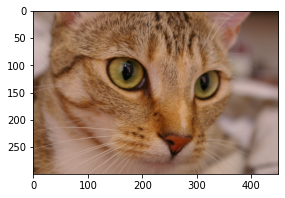

In [1]:
#scikit learn 고양이 이미지

from skimage import data
import matplotlib.pyplot as plt

hr_image = data.chelsea()
print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(100, 150, 3)


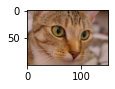

In [2]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150,100))      #이미지 리사이징(150, 100)

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)


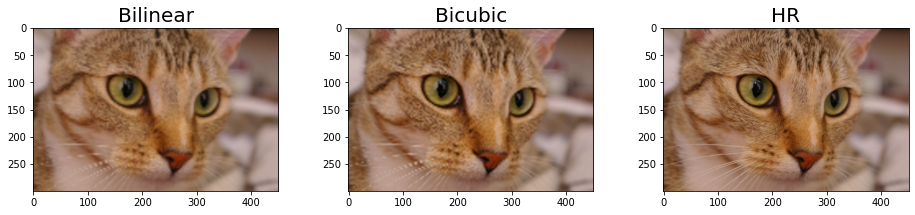

In [3]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### SRCNN (Super Resolution CNN)

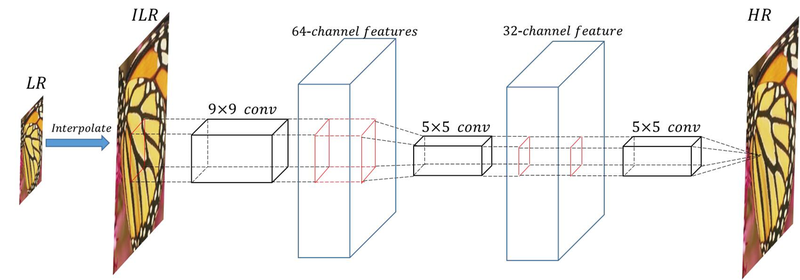

- 가장 먼저 저해상도 이미지를 interpolation을 하여 원하는 크기로 이미지를 늘린다.
- 이후 3개의 convolutional layer를 거쳐 고해상도 이미지를 생성한다.
- 생성된 고해상도 이미지와 실제 고해상도 이미지의 차이를 backpropagation 하여 Weight를 학습한다.
- 학습할 때 loss function은 MSE를 사용한다.

### VDSR (Very Deep Super Resolution)

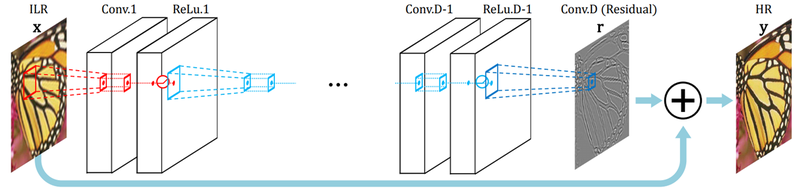

- SRCNN과 동일하게 interpolation을 통해 저해상도 이미지의 크기를 늘려 입력으로 사용한다.
- convolution layer를 20개를 사용한다.
- 최종 고해상도 이미지 생성 직전에 처음 입력 이미지를 더한다. (Residual learning)

### RDN (Residual Dense Network)

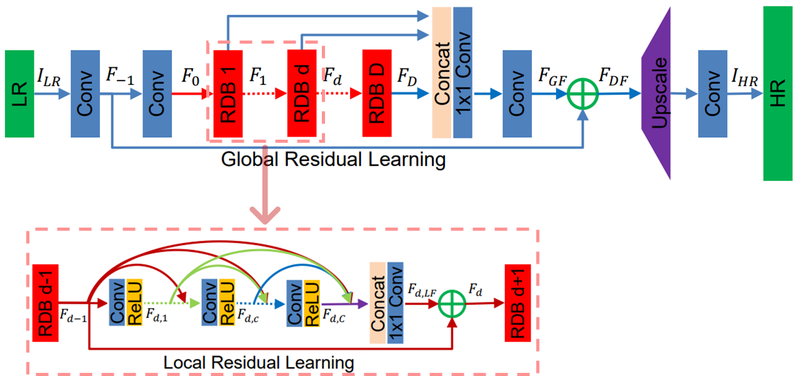

- 저해상도 이미지가 입력되면 여러 단계의 convolution layer를 거치는데 각 layer에서 나오는 출력을 최대한 활용한다.

### RCAN (Residual Channel Attention Networks)

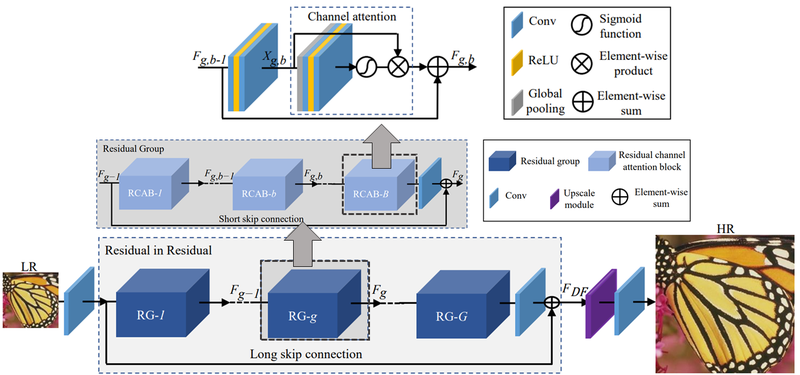

- RCAN 또한 많은 convolutional layer를 거치지만 특별한 점은 convolutional layer의 결과인 각각의 특징 맵을 대상으로 일부 중요한 채널에만 선택적으로 집중하도록 유도한다.

## 2. SRCNN을 이용한 Super Resolution

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


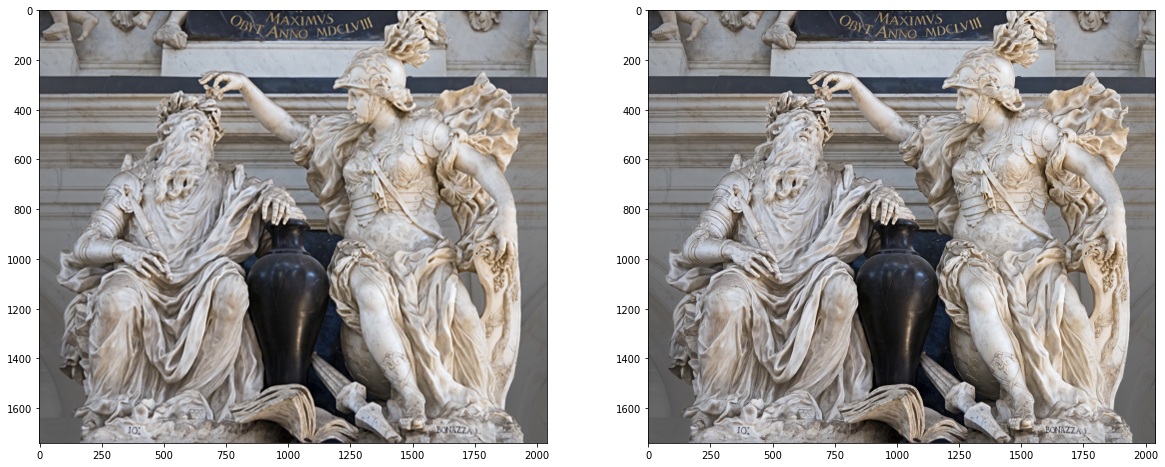

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

#load data
train, valid = tfds.load(
    'div2k/bicubic_x4',
    split=['train', 'validation'],
    as_supervised=True)

#시각화를 위해 한 개의 데이터만 선택
for i, (lr, hr) in enumerate(valid):
    if i == 6:
        break
        
#저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(lr, 
                       dsize=(hr.shape[1], hr.shape[0]),
                       interpolation = cv2.INTER_CUBIC)

#저해상도 및 고해상도 이미지를 시각화
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

Text(0.5, 1.0, 'HR')

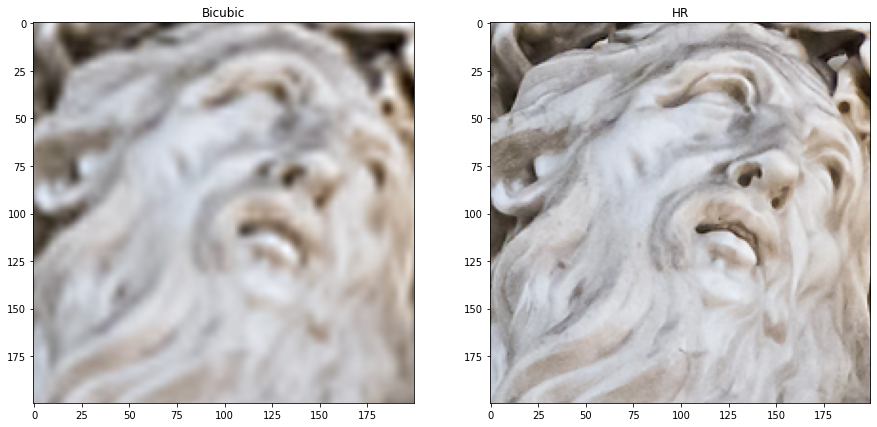

In [5]:
# 차이를 모르겠으니 이미지의 특정부분을 잘라보자
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라낸다
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분 시가화
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title('Bicubic')
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title('HR')

- SRCNN의 학습결과는 얼마나 좋은지 확인해보자.

In [6]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용
    hr = tf.image.random_crop(hr, size=[96,96,3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌려서 만든 저해상도 이미지를 입력으로 사용
    lr = tf.image.resize(hr, [96//4, 96//4], 'bicubic')
    lr = tf.image.resize(lr, [96, 96], 'bicubic')
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)

- SRCNN 구현

In [7]:
from tensorflow.keras import layers, Sequential

srcnn = Sequential()

srcnn.add(layers.Conv2D(128, 9, padding='same', input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())

srcnn.add(layers.Conv2D(64, 5, padding='same'))
srcnn.add(layers.ReLU())

srcnn.add(layers.Conv2D(3, 5, padding='same'))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [8]:
srcnn.compile(optimizer='adam', loss='mse')

srcnn.fit(train, validation_data=valid, epochs=1)

50/50 [==============================] - 62s 918ms/step - loss: 0.0761 - val_loss: 0.0145


- srcnn 테스트

In [9]:
import tensorflow as tf
import os

# 학습시간이 길어서 이미 학습된 srcnn 모델을 사용
model_file = os.getenv('HOME') + '/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

In [10]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...] / 255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr = sr*255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

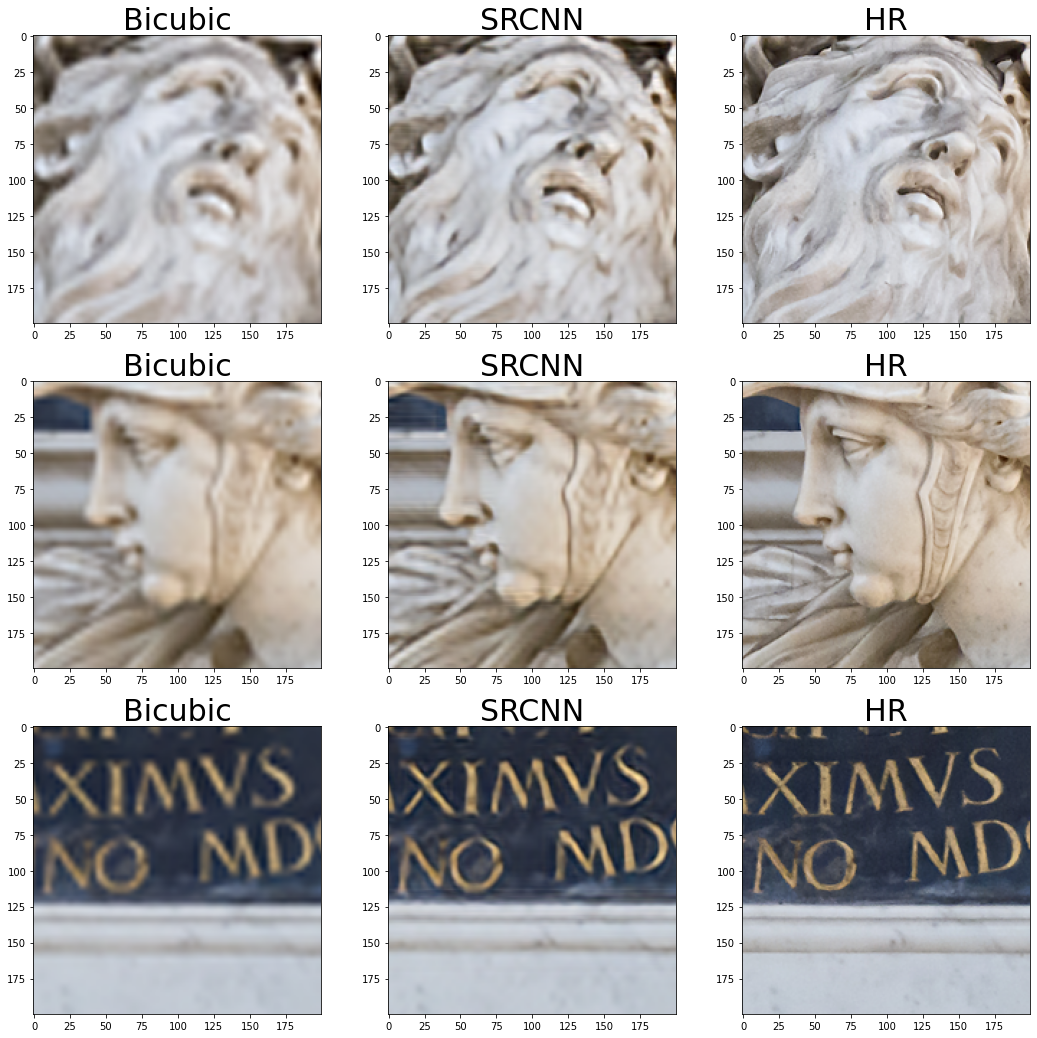

In [11]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### (3) Deep learning을 이용한 Super Resolution (SRGAN)

- SRCNN은 생성된 고해상도 이미지를 원래 고해상도 이미지와 직접 비교하여 loss를 계산했지만 SRGAN은 생성된 고해상도 이미지와 실제 고해상도 이미지를 VGG에 입력하여 모델 중간에서 추출해낸 특징을 비교한다.
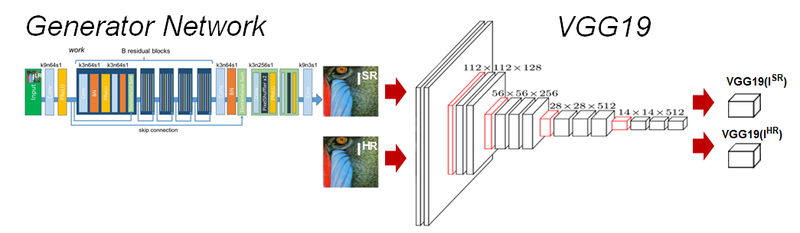

In [20]:
train, valid = tfds.load('div2k/bicubic_x4', split=['train', 'validation'], as_supervised=True)

def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 이미지의 크기가 크므로 (96, 96, 3) 크기로 임의 영역을 잘라내어 사용
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄인다. (이 저해상도 이미지를 SRGAN의 입력으로 사용)
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], 'bicubic')
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)

- SRGAN 구현

1. Generator 구현
- 저해상도 이미지를 입력받아 고해상도 이미지를 생성 
   
   
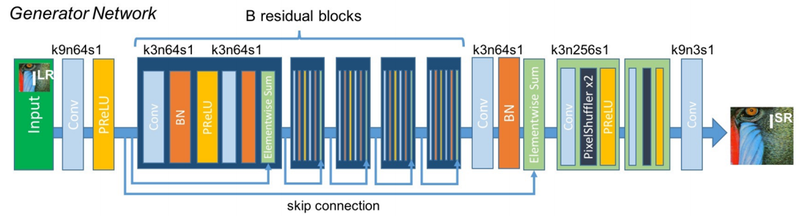
   
-k9n64s1은 (kernel size, filters, strides 의 hyperparameter이다!)

In [22]:
from tensorflow.keras import Input, Model, layers

# 그림의 남색 블록 정의
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 연두색 블록 정의
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    # 남색 블록 5번
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    # 연두색 블록 2번
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

2. Discriminator 구현

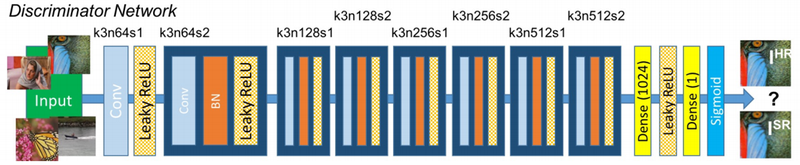

In [23]:
# 그림의 남색 블록 정의
def disc_base_block(x, n_filters):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    #남색 블록 128 -> 128 -> 256 -> 256 -> 512 -> 512
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

- SRGAN은 VGG19을 이용해 content loss를 계산한다. Tensorflow는 이미지넷 데이터로부터 잘 학습된 VGG19를 제공하고 있다.

In [24]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer
    return Model(vgg.input, vgg.layers[20].output)

- SRGAN 학습하기

In [25]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

80142336/80134624 [==============================] - 1s 0us/step
EPOCH[1] - STEP[10] 
Generator_loss:0.0012 
Discriminator_loss:1.8329

EPOCH[1] - STEP[20] 
Generator_loss:0.0013 
Discriminator_loss:1.3059

EPOCH[1] - STEP[30] 
Generator_loss:0.0016 
Discriminator_loss:0.9866

EPOCH[1] - STEP[40] 
Generator_loss:0.0021 
Discriminator_loss:0.7741

EPOCH[1] - STEP[50] 
Generator_loss:0.0026 
Discriminator_loss:0.6258

EPOCH[1] - STEP[60] 
Generator_loss:0.0032 
Discriminator_loss:0.5231

EPOCH[1] - STEP[70] 
Generator_loss:0.0037 
Discriminator_loss:0.4490

EPOCH[1] - STEP[80] 
Generator_loss:0.0041 
Discriminator_loss:0.3933

EPOCH[1] - STEP[90] 
Generator_loss:0.0044 
Discriminator_loss:0.3498

EPOCH[1] - STEP[100] 
Generator_loss:0.0047 
Discriminator_loss:0.3150

EPOCH[1] - STEP[110] 
Generator_loss:0.0050 
Discriminator_loss:0.2865

EPOCH[1] - STEP[120] 
Generator_loss:0.0052 
Discriminator_loss:0.2627

EPOCH[1] - STEP[130] 
Generator_loss:0.0054 
Discriminator_loss:0.2426

EPOCH[1]

- SRGAN 테스트하기

In [27]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'    #srgan_G.h5는 학습이 완료된 generator이다.
srgan = tf.keras.models.load_model(model_file) 

In [28]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)

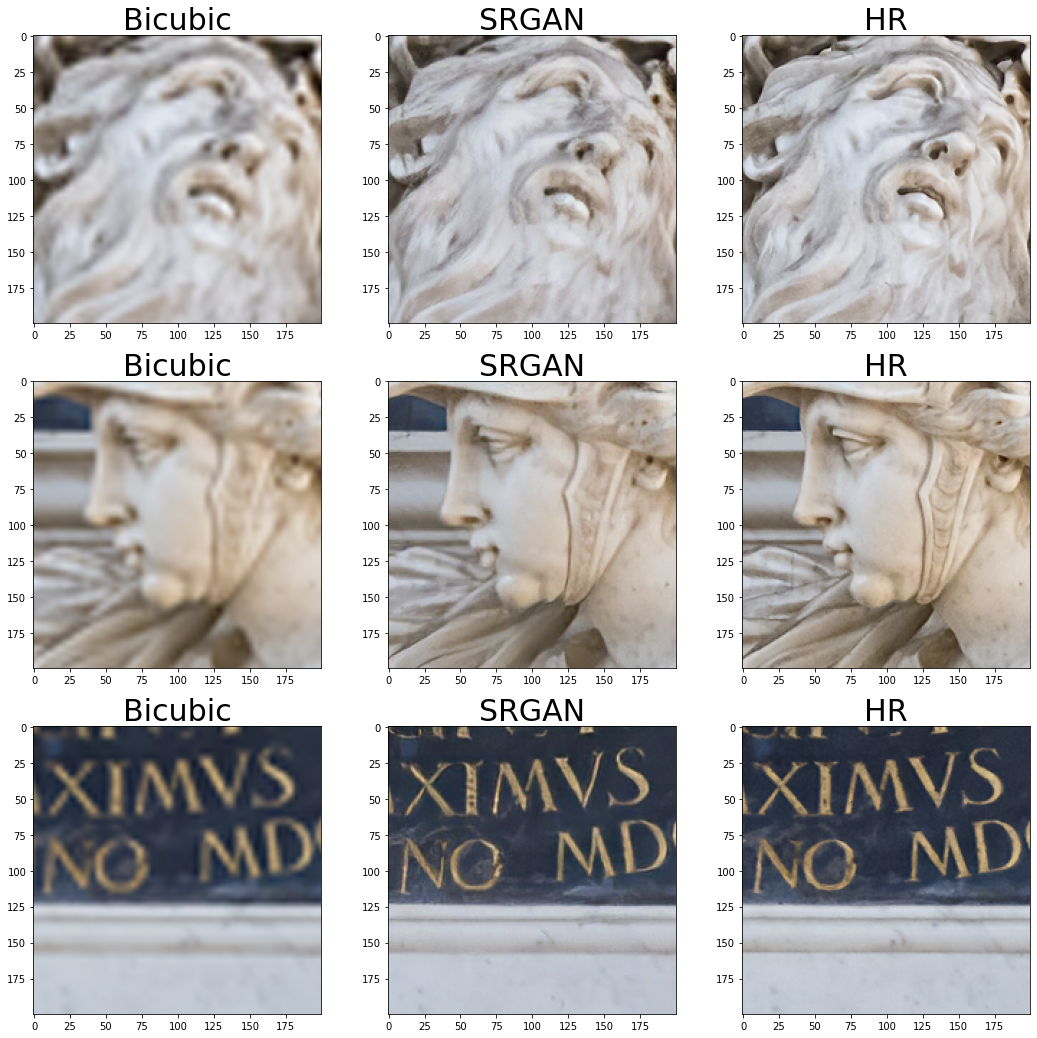

In [29]:
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

- SRCNN SRGAN 결과 비교

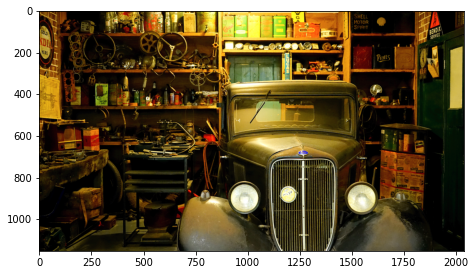

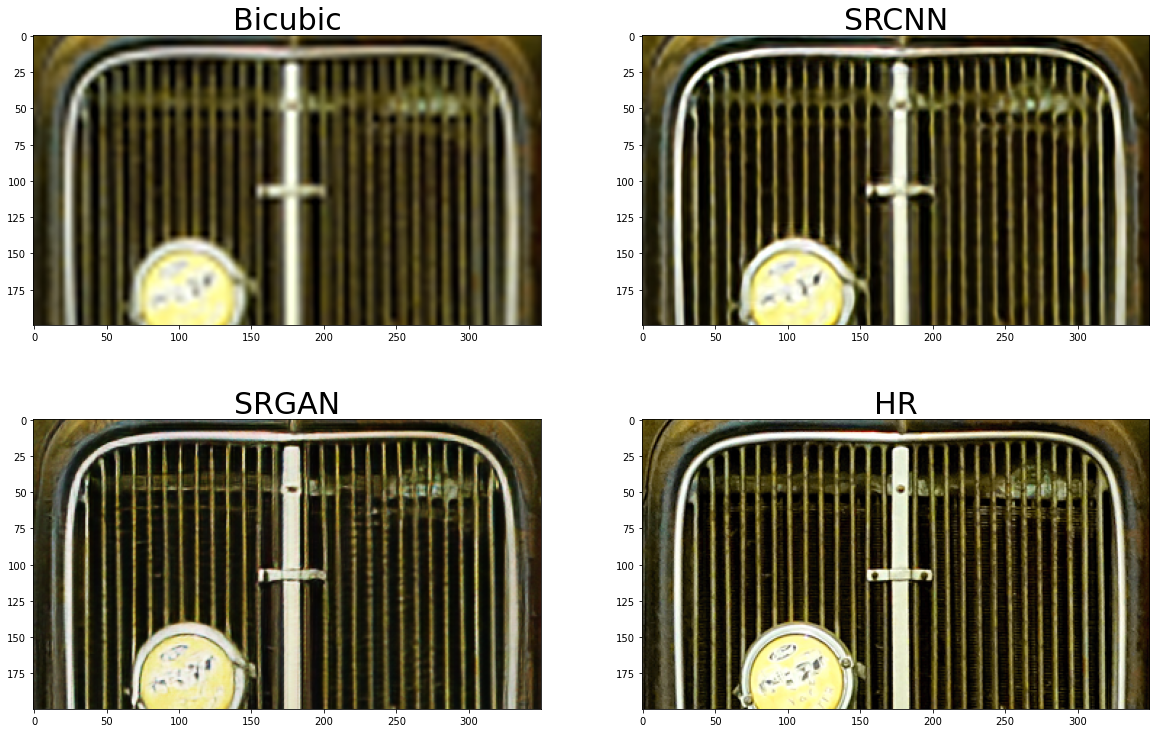

In [30]:
for i, (lr, hr) in enumerate(valid):
    if i == 12: break # 12번째 이미지를 불러온다

lr_img, hr_img = np.array(lr), np.array(hr)

# bicubic interpolation
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

# 전체 이미지를 시각화
plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

# SRCNN을 이용해 고해상도로 변환
srcnn_img = apply_srcnn(bicubic_img)

# SRGAN을 이용해 고해상도로 변환
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (700, 1090) # 잘라낼 부분의 왼쪽 상단 좌표를 지정

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화
plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

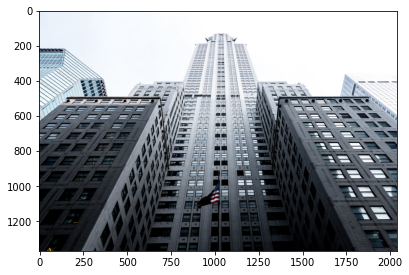

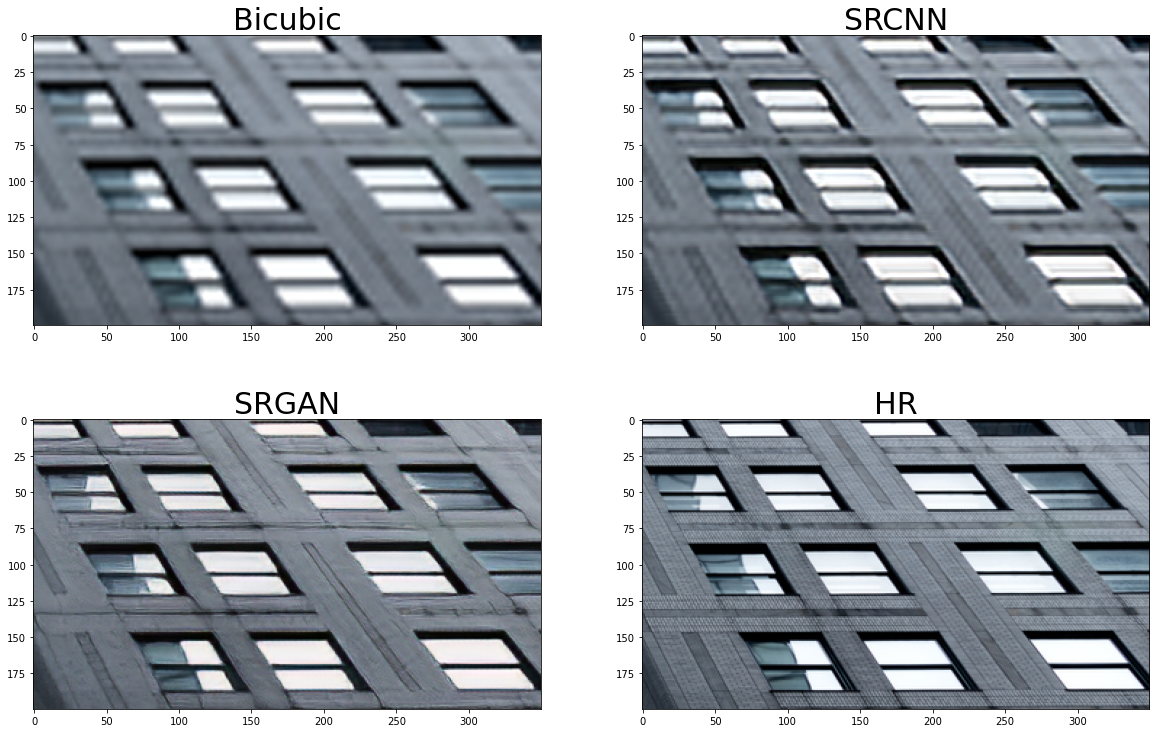

In [31]:
for i, (lr, hr) in enumerate(valid):
    if i == 15: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (600, 1500)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


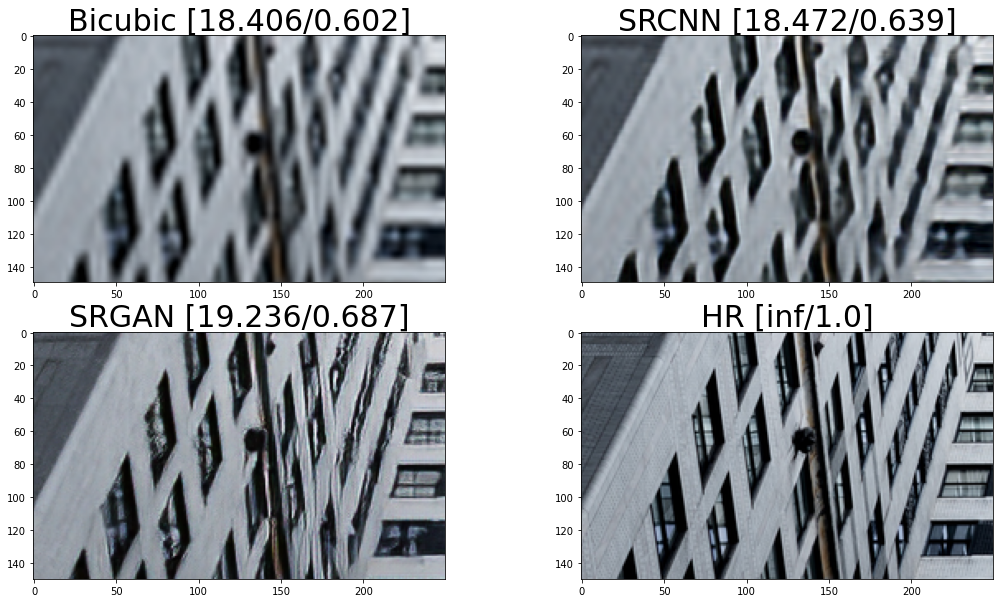

In [33]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

left_top = (620, 570)
crop_images = [crop(i, left_top, 150, 250) for i in images]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)